In [2]:
%matplotlib inline 
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns
from astropy.io import fits
from sklearn.cross_validation import train_test_split

/Users/tinapeters/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
file = "Peters2015Catalog_30042015.fit"
qso_data = fits.open(file)[1].data

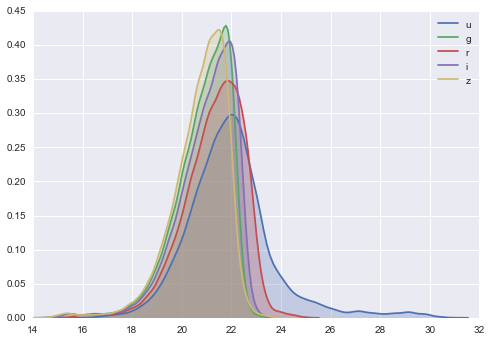

In [45]:
sns.kdeplot(qso_data.coadd_u,shade=True, label='u')
sns.kdeplot(qso_data.coadd_i,shade=True, label='g')
sns.kdeplot(qso_data.coadd_g,shade=True, label='r')
sns.kdeplot(qso_data.coadd_r,shade=True, label='i')
sns.kdeplot(qso_data.coadd_z,shade=True, label='z')
plt.legend()

In [6]:
training_set = qso_data[qso_data['zspec'] > 0.0]
test_set = qso_data[qso_data['zspec'] < 0.0]

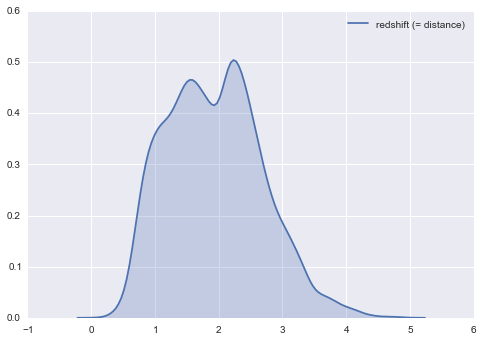

In [31]:
sns.kdeplot(training_set.zspec, shade=True, label= 'redshift (= distance)')

In [46]:
features = np.array([training_set['coadd_u'], training_set['coadd_g'], training_set['coadd_r'], training_set['coadd_i'], training_set['coadd_z']]).T
labels = training_set['zspec']

In [14]:
X_train, X_test, y_train, y_test,= train_test_split(features, labels, test_size=0.25, random_state=42)

In [15]:
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(10064, 5) (3355, 5) (10064,) (3355,)


# Decision Tree

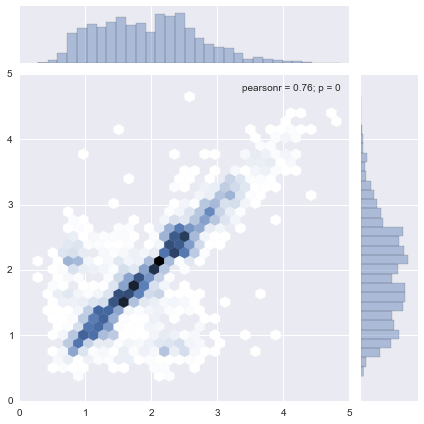

In [41]:
from sklearn import tree

clf = tree.DecisionTreeRegressor(max_depth=100)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

sns.jointplot(y_test, y_hat, xlim=(0,5), ylim=(0,5), kind="hex", mincnt=1)

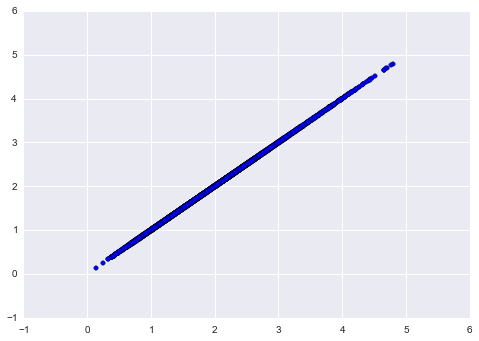

In [36]:
y_hat_train= clf.predict(X_train)
plt.scatter(y_train, y_hat_train)

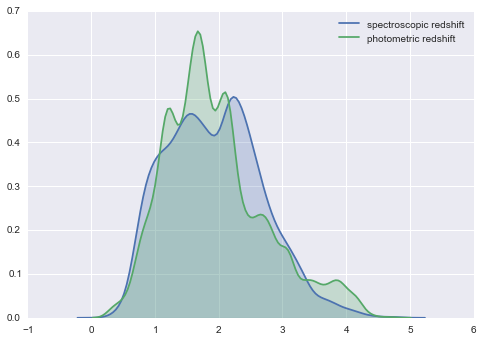

In [51]:
test_features = np.array([test_set['coadd_u'], test_set['coadd_g'], test_set['coadd_r'], test_set['coadd_i'], test_set['coadd_z']]).T
test_labels_clf = clf.predict(test_features)
sns.kdeplot(training_set.zspec, shade=True, label= 'spectroscopic redshift')
sns.kdeplot(test_labels_clf, shade=True, label= 'photometric redshift')

In [47]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

print 'Error on test set', mse(y_test, y_hat)
print 'Error on training set', mse(y_train, y_hat_train)

Error on test set 0.270367413656
Error on training set 3.84935040884e-10


# Random Forest

Single Tree on Test set 0.270144846177
Random Forest on Test set 0.152731824158


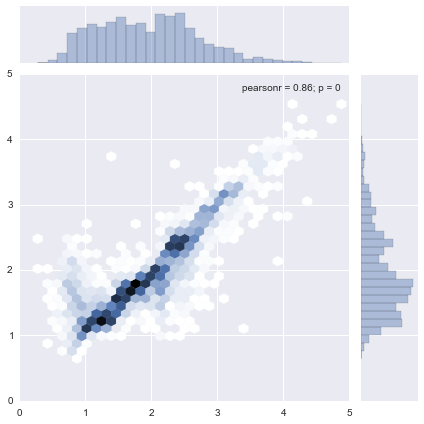

In [40]:
from sklearn.ensemble import RandomForestRegressor as rfr
estimator = rfr(n_estimators=10)
estimator = estimator.fit(X_train, y_train)
y_hat_rf = estimator.predict(X_test)

sns.jointplot(y_test,y_hat_rf, xlim=(0,5), ylim=(0,5), kind="hex", mincnt=1)
print 'Single Tree on Test set', mse(y_test, y_hat)
print 'Random Forest on Test set', mse(y_test, y_hat_rf)

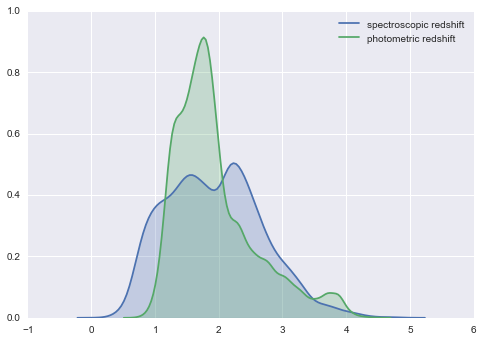

In [52]:
test_labels_rf = estimator.predict(test_features)
sns.kdeplot(training_set.zspec, shade=True, label= 'spectroscopic redshift')
sns.kdeplot(test_labels_rf, shade=True, label= 'photometric redshift')

# Grid Search

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.7, max_leaf_nodes=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Single Tree on Test set 0.270367413656
Random Forest on Test set 0.152731824158
Random Forest Grid Search on Test set 0.146034550252


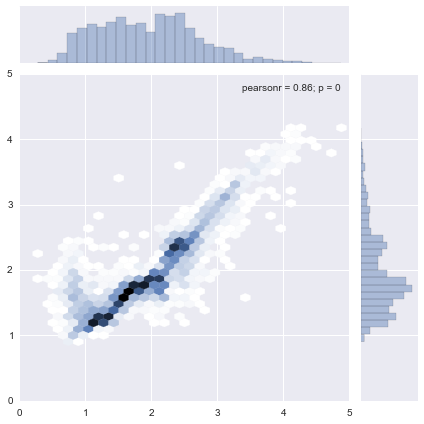

In [42]:
from sklearn.grid_search import GridSearchCV
gs_rfr = rfr()

params = {'n_estimators':(20,50,100),
          'min_samples_split':(2,20),
          'min_samples_leaf':(10,30),
          'max_features':(0.7,0.5,0.3)
          }

grid_search = GridSearchCV(gs_rfr,param_grid=params,n_jobs=-1, verbose=0, cv=5)
grid_search.fit(X_train, np.ravel(y_train))
print grid_search.best_estimator_
y_hat_rf_grid_search = grid_search.predict(X_test)

sns.jointplot(y_test, y_hat_rf_grid_search, xlim=(0,5), ylim=(0,5), kind="hex", mincnt=1)
print 'Single Tree on Test set', mse(y_test, y_hat)
print 'Random Forest on Test set', mse(y_test, y_hat_rf)
print 'Random Forest Grid Search on Test set', mse(y_test, y_hat_rf_grid_search)

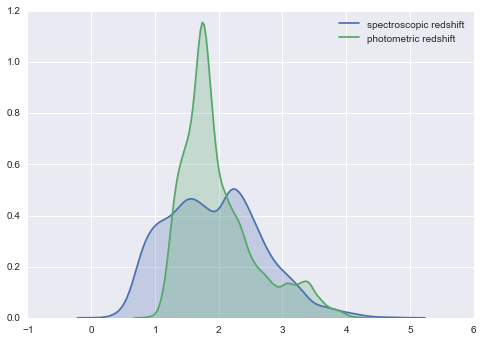

In [53]:
test_labels_rf_grid_search = grid_search.predict(test_features)
sns.kdeplot(training_set.zspec, shade=True, label= 'spectroscopic redshift')
sns.kdeplot(test_labels_rf_grid_search, shade=True, label= 'photometric redshift')